## Introduction

## Jupyter Notebook Setup

In [ ]:
import pandas as pd
import numpy as np
import os
from collections import Counter
import string
import spacy
from spacy.lang.en.stop_words import STOP_WORDS as stop
from nltk.stem import SnowballStemmer
from tqdm import tqdm
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import warnings

In [ ]:
warnings.filterwarnings('ignore')
nlp = spacy.load("en_core_web_sm")
punc = set(string.punctuation)
stemmer = SnowballStemmer('english')
plt.rcParams['figure.figsize'] = (18, 8)

In [ ]:
# Plotly renderer setup.
import plotly.io as pio
pio.renderers.default = 'iframe+colab+notebook'

## Reading The Data

In [ ]:
from google.colab import drive 
drive.mount('/content/gdrive')

df = pd.read_csv('gdrive/My Drive/amazon_scraped_data.csv')
df.head()

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Unnamed: 0  ...                                               text
0           0  ...  Great Phone, I am happy with the phone so far....
1           1  ...  Your browser does not support HTML5 video. Iph...
2           2  ...  When compared with XS only visible difference ...
3           3  ...  Your browser does not support HTML5 video. I c...
4           4  ...  Upgraded from 5s to xr after 3 years of 5s use...

[5 rows x 6 columns]

In [ ]:

df = df.drop(columns=['Unnamed: 0'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 890 entries, 0 to 889
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   title     890 non-null    object 
 1   date      890 non-null    object 
 2   location  890 non-null    object 
 3   rating    890 non-null    float64
 4   text      890 non-null    object 
dtypes: float64(1), object(4)
memory usage: 34.9+ KB


## Data Exploration

In [ ]:
df['date'] = df['date'].apply(pd.to_datetime)
df_ts = df.set_index('date')
df['date'].describe()

count                     890
unique                    306
top       2019-11-03 00:00:00
freq                       23
first     2018-10-27 00:00:00
last      2021-01-24 00:00:00
Name: date, dtype: object

In [ ]:
z = df_ts.resample('W')['rating'].agg(['mean', 'count'])
x = z.index.map(lambda x: str(x)[:10] + ' - ' + str(pd.offsets.DateOffset(6) + x)[:10])
ticks = [
    ['End of Q4 2018', (2019,1,1)], 
    *[[f'End of Q{i+1} 2019', (2019 if i < 3 else 2020, 4+i*3 if i < 3 else 1, 1)] for i in range(4)], 
    *[[f'End of Q{i+1} 2020', (2020, 4+i*3 , 1)] for i in range(2)], 
]

ticktext, tickvals = [], []
for i in ticks:
    idx = np.where(z.index > pd.Timestamp(*i[1]))[0][0] - 1
    ticktext.append(i[0])
    tickvals.append(x[idx])

# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add traces
fig.add_trace(
    go.Scatter(
        x=x, 
        y=z['mean'],
        name='Average Rating Score',
        mode='lines',
    ),
    secondary_y=True,
)
fig.add_trace(
    go.Bar(x=x, y=z['count'],name='Ratings Count'),
    secondary_y=False,
)

# Update plot title & legend
fig.update_layout(
    title=dict(text='Product Reviews', x=0.5),
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="right",
        x=0.945
    )
)

# Update x-axis
fig.update_xaxes(
    title_text="Time",
    ticktext=ticktext,
    tickvals=tickvals,
    tickangle=-90,
#     rangeslider_visible=True,
)

# Update y-axes titles
fig.update_yaxes(title_text="Ratings Count", secondary_y=False)
fig.update_yaxes(title_text="Average Rating Score", secondary_y=True)
                  
# Show figure
fig.show()

In [ ]:
dates = []
ratings_count = []

for date in tqdm(df['date'].unique()):
    dates.append(date)
    ratings = df_ts.loc[date, 'rating']
    if type(ratings)==np.float64:
        ratings = [ratings]
    count = [0, 0, 0, 0]
    for rating in ratings:
        if rating == 5:
            count[3] += 1
        elif rating >= 4:
            count[2] += 1
        elif rating <= 2:
            count[0] += 1
        else:
            count[1] += 1
    ratings_count.append(count)

y = ['Bad', 'Neutral', 'Good', 'Perfect']
df_ratings = pd.DataFrame(ratings_count, dates, columns = y).resample('W').sum().reset_index()
df_ratings.columns = ['period', *y]
df_ratings['period'] = x
df_ratings.head()

100%|██████████| 306/306 [00:00<00:00, 1809.62it/s]


period  Bad  Neutral  Good  Perfect
0  2018-10-28 - 2018-11-03    1        0     0        1
1  2018-11-04 - 2018-11-10    0        0     0        0
2  2018-11-11 - 2018-11-17    0        0     0        0
3  2018-11-18 - 2018-11-24    0        0     1        0
4  2018-11-25 - 2018-12-01    0        0     0        0

In [ ]:
fig = px.histogram(df, 'rating', marginal='box')
fig.update_layout(title=dict(text='Rating Distribution', x=0.5))

fig.show()

In [ ]:
df['location'].value_counts()

India    890
Name: location, dtype: int64

In [ ]:
fig = px.histogram(df['text'].apply(lambda x: len(x.split())), 'text', marginal = 'box')
fig.update_layout(title=dict(text='Text Words Count Distribution', x=0.5))

fig.show()

In [ ]:
fig = px.histogram(df['text'].apply(lambda x: np.clip(len(x.split()), 0, 50)), 'text', marginal = 'box')
fig.update_layout(title=dict(text='Text Words Count Distribution (clipped)', x=0.5))

fig.show()

In [ ]:
fig = px.histogram(df['title'].apply(lambda x: len(x.split())), 'title', marginal = 'box')
fig.update_layout(title=dict(text='Title Words Count Distribution', x=0.5))

fig.show()

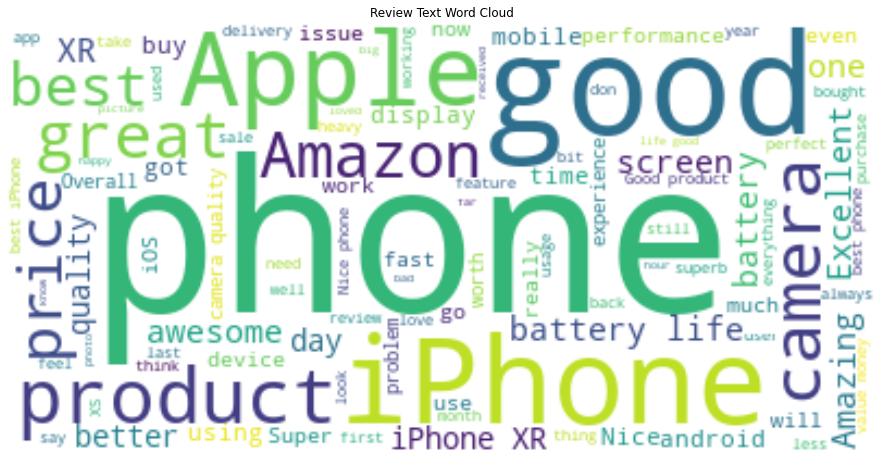

In [ ]:
wordcloud = WordCloud(
    background_color='white',
    max_words=100,
#     stopwords=stop
).generate('\n'.join(list(df['text'])))

plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Review Text Word Cloud')
plt.axis("off")
plt.show()

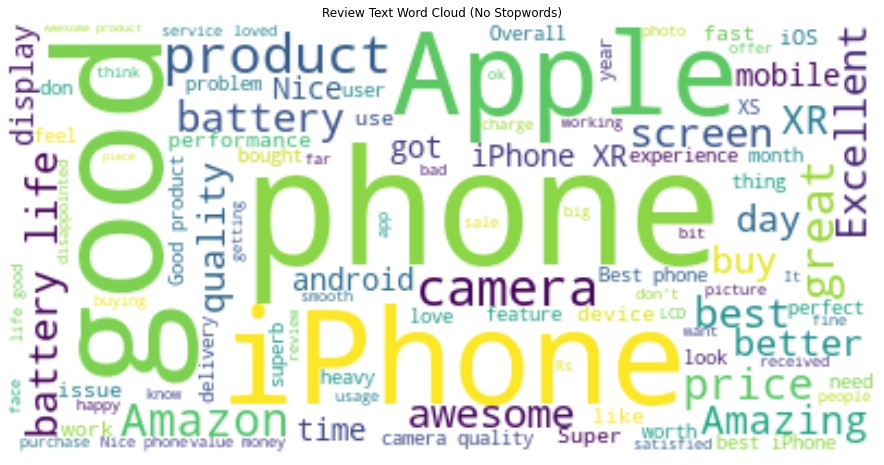

In [ ]:
wordcloud = WordCloud(
    background_color='white',
    max_words=100,
    stopwords=stop
).generate('\n'.join(list(df['text'])))

plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Review Text Word Cloud (No Stopwords)')
plt.axis("off")
plt.show()

100%|██████████| 890/890 [00:00<00:00, 47256.47it/s]


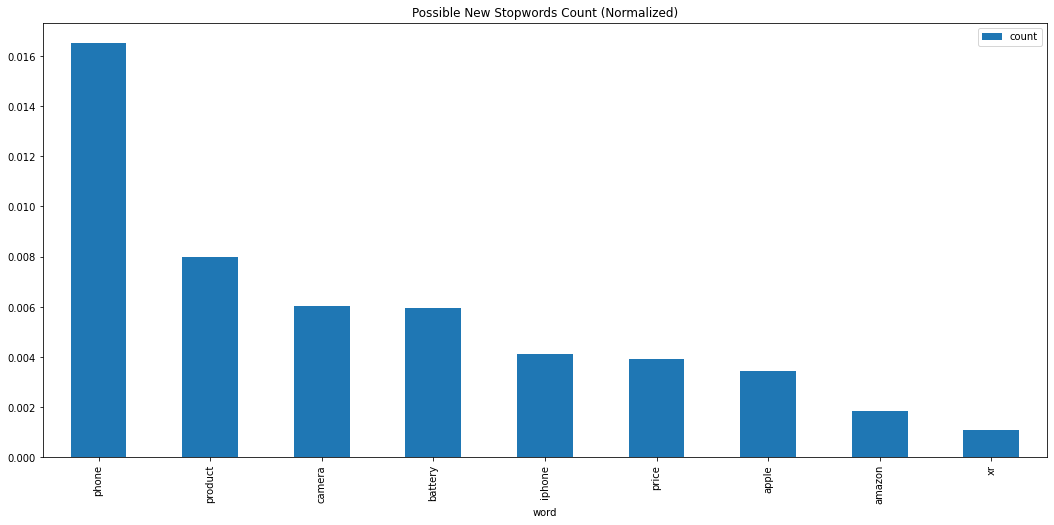

In [ ]:
new_stopwords = ['amazon', 'phone', 'xr', 'iphone', 'apple', 'product', 'camera', 'price', 'battery']
word_count = Counter()

for text in tqdm(df['text']):
    text = ''.join([i for i in text if i not in punc])
    for word in text.split():
        if word in new_stopwords:
            word_count[word] += 1
            
(pd.DataFrame(word_count.most_common(), columns='word count'.split())\
    .set_index('word') / df['text'].apply(lambda x: len(x.split())).sum())\
    .plot.bar(title='Possible New Stopwords Count (Normalized)')
plt.show()

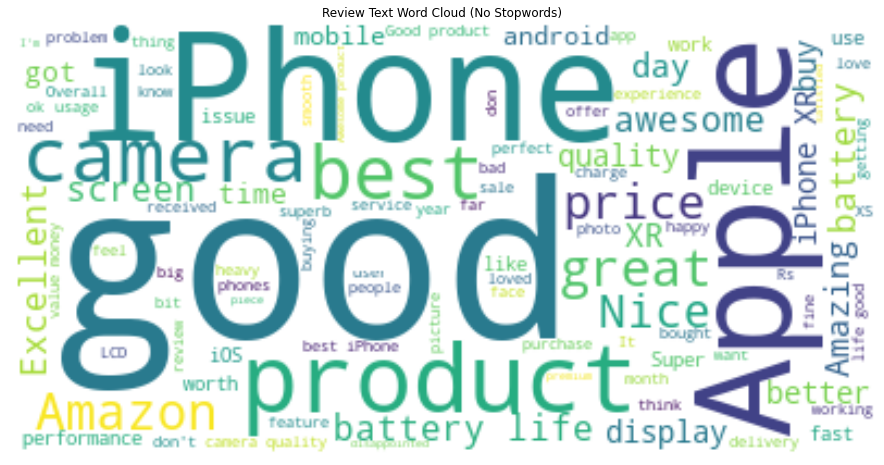

In [ ]:
stop.add('phone')

wordcloud = WordCloud(
    background_color='white',
    max_words=100,
    stopwords=stop
).generate('\n'.join(list(df['text'])))

plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Review Text Word Cloud (No Stopwords)')
plt.axis("off")
plt.show()

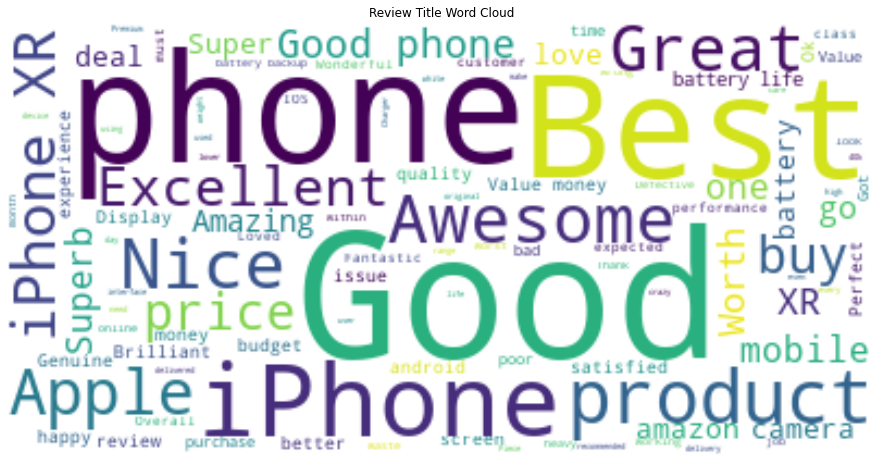

In [ ]:
wordcloud = WordCloud(
    background_color='white',
    max_words=100,
#     stopwords=stop
).generate('\n'.join(list(df['title'])))

plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Review Title Word Cloud')
plt.axis("off")
plt.show()

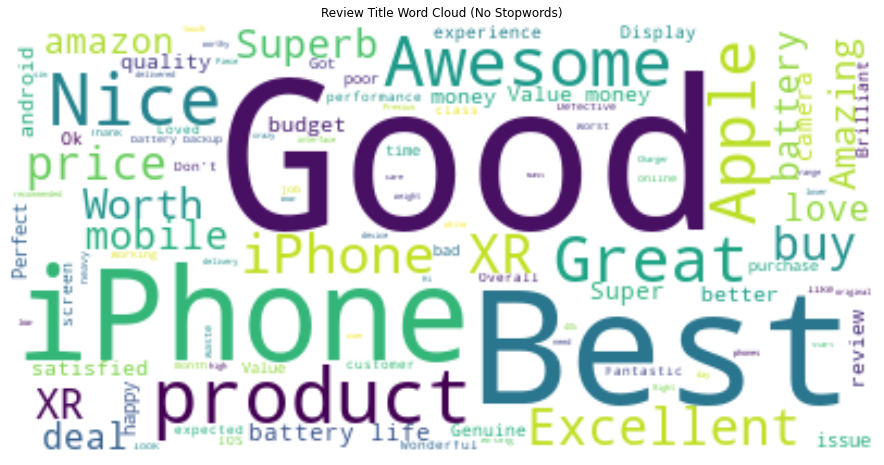

In [ ]:
wordcloud = WordCloud(
    background_color='white',
    max_words=100,
    stopwords=stop
).generate('\n'.join(list(df['title'])))

plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Review Title Word Cloud (No Stopwords)')
plt.axis("off")
plt.show()

In [ ]:
punc = set(string.punctuation)

text_word_counter = Counter()
title_word_counter = Counter()
text_adj_counter = Counter()
text_adv_counter = Counter()
text_word_unique_appearence_frequency = Counter()
title_word_unique_appearence_frequency = Counter()

for idx in tqdm(df.index):
    text, title = df.loc[idx, ['text', 'title']]
    text = ''.join([i for i in text.lower() if i not in punc])
    title = ''.join([i for i in title.lower() if i not in punc])
    ttitle_words, ttext_words = set(), set()
    for token in nlp(text):
        if token.is_space:
            break
        word = token.text
        pos = token.pos_
        if pos == 'ADV':
            text_adv_counter[word] += 1
        elif pos == 'ADJ':
            text_adj_counter[word] += 1
        for ttext in df['text']:
            if word in ttext_words:
                break
            elif word in ttext.lower():
                text_word_unique_appearence_frequency[word] += 1
                ttext_words.add(word)
                break
        if word not in stop:
            text_word_counter[word] += 1
    for token in nlp(title):
        if token.is_space:
            break
        word = token.text
        for ttile in df['title']:
            if word in ttitle_words:
                break
            elif word in ttile.lower():
                title_word_unique_appearence_frequency[word] += 1
                ttitle_words.add(word)
                break
        if word not in stop:
            title_word_counter[word] += 1

100%|██████████| 890/890 [00:28<00:00, 31.40it/s]


In [ ]:
def visualize_counter(counter, title, xlabel='Word', ylabel='Frequency', n=50, descending=True):
    '''
    Visualize word frequency count from a Counter object
    '''
    z = counter.most_common()
    if descending:
        x = [i[0] for i in z][:n]
        y = [i[1] for i in z][:n]
    else:
        x = [i[0] for i in z][-n:]
        y = [i[1] for i in z][-n:]

    fig = go.Figure(
        data=[go.Bar(x=x, y=y)],
        layout=dict(
            title=dict(text=title, x=0.5),
            xaxis=dict(title_text=xlabel),
            yaxis=dict(title_text=ylabel),
        ),
    )

    fig.show()

In [ ]:
visualize_counter(text_adv_counter, 'Text Adverbs Frequency')

In [ ]:
visualize_counter(text_adj_counter, 'Text Adjectives Frequency')

In [ ]:
visualize_counter(text_word_counter, 'Text Word Frequency')

In [ ]:
visualize_counter(title_word_counter, 'Title Word Frequency')

In [ ]:
visualize_counter(text_word_unique_appearence_frequency, 'Word Appearence in Review\'s Text')

In [ ]:
visualize_counter(title_word_unique_appearence_frequency, 'Word Appearence in Review\'s Title')

## Data Cleaning

In [ ]:
def clean(doc):
    # lower text and remove punctuations
    s = ''
    for char in doc.lower():
        s += char if char not in punc else ' '
    # remove stopwords, adjectives, and adverbs
    normalized = []
    for token in nlp(s):
        if not (token.is_space or token.is_stop or token.pos_ == 'ADJ' or token.pos_ == 'ADV'):
            # stem and lemmatize text
            t = stemmer.stem(token.lemma_)
            normalized.append(t)
    normalized = " ".join(normalized)
    return normalized

In [ ]:
df['text'][31]

'After 2 weeks of usages I am giving my review:Pros:1. Performance is of the highest quality very smooth and no lags.2. Battery life is the best easily survives 1 day with 80-85% battery.3. Storage optimisation is very good.4. Camera is very good but not the best.5. Sound is very loud of the speakers.6. No heating at all.7. Design is premium.Cons:1. Camera could have been better lighting is little less and night mode is not included therefore it can’t take good night photos. ( Portrait mode only available for humans)2. Display is good but it is not the best in the price range.3. No 3d touch.'

In [ ]:
clean(df['text'][31])

'2 week usag give review pro 1 perform qualiti lag 2 batteri life surviv 1 day 80 85 batteri 3 storag optimis 4 camera 5 sound speaker 6 heat 7 design con 1 camera light night mode includ night photo portrait mode human 2 display price rang 3 touch'

In [ ]:
text_clean = [clean(doc) for doc in tqdm(df['text'])]
title_clean = [clean(doc) for doc in tqdm(df['title'])]

df['title_clean'] = title_clean
df['text_clean'] = text_clean

df.head()

100%|██████████| 890/890 [00:10<00:00, 88.41it/s]


title  ...                                         text_clean
0  Great phone, if you don't care about OLED scre...  ...  thing notic differ xs xr 1 touch don t feel ma...
1  Just don’t buy it from amazon totally waste of...  ...  browser support html5 video iphon receiv piec ...
2                                  Worth Every Penny  ...  compar xs differ screen keep prefer xs prosava...
3                                 Blindly go for it.  ...  browser support html5 video choos iphon xr x r...
4           Apple's Perfection at a premium but ....  ...  upgrad 5s xr 3 year use purchas ₹37999 batteri...

[5 rows x 7 columns]

In [ ]:
df[(df['text_clean'].apply(lambda x: x.strip()) == '')].shape

(194, 7)

In [ ]:
df = df[(df['text_clean'].apply(lambda x: x.strip()) != '')]

## Save cleaned data

In [ ]:

# Import Drive API and authenticate.
from google.colab import drive

# Mount your Drive to the Colab VM.
drive.mount('/gdrive')

# Write the DataFrame to CSV file.
with open('/gdrive/My Drive/cleaned_data.csv', 'w') as f:
  df.to_csv(f)

Mounted at /gdrive


## Post-Cleaning Data Exploration

In [ ]:
# stop = set(stopwords.words('english'))

text_word_counter = Counter()
title_word_counter = Counter()
text_word_unique_appearence_frequency = Counter()
title_word_unique_appearence_frequency = Counter()

for idx in tqdm(df.index):
    text, title = df.loc[idx, ['text_clean', 'title_clean']]
    text = text.lower()
    title = title.lower()
    ttitle_words, ttext_words = set(), set()
    for word in text.split():
        for ttext in df['text']:
            if word in ttext_words:
                continue
            elif word in ttext.lower():
                text_word_unique_appearence_frequency[word] += 1
                ttext_words.add(word)
        if word not in stop:
            text_word_counter[word] += 1
    for word in title.split():
        for ttile in df['title']:
            if word in ttitle_words:
                continue
            elif word in ttile.lower():
                title_word_unique_appearence_frequency[word] += 1
                ttitle_words.add(word)
        if word not in stop:
            title_word_counter[word] += 1
else:
    total_words_in_text = sum(text_word_counter.values())
    total_words_in_title = sum(title_word_counter.values())
    for k, v in text_word_counter.items():
        text_word_counter[k] = v / total_words_in_text
    for k, v in text_word_unique_appearence_frequency.items():
        text_word_unique_appearence_frequency[k] = v / df.shape[0]
    for k, v in title_word_counter.items():
        title_word_counter[k] = v / total_words_in_title
    for k, v in title_word_unique_appearence_frequency.items():
        title_word_unique_appearence_frequency[k] = v / df.shape[0]

100%|██████████| 696/696 [00:02<00:00, 335.32it/s]


In [ ]:
visualize_counter(text_word_counter, 'Text Word Frequency (Normalized)')

In [ ]:
visualize_counter(title_word_counter, 'Text Word Frequency (Normalized)')

In [ ]:
visualize_counter(text_word_unique_appearence_frequency, 'Word Appearence in Review\'s Text (Normalized)')

In [ ]:
visualize_counter(title_word_unique_appearence_frequency, 'Word Appearence in Review\'s Title (Normalized)')